In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from config import *
import importlib
import sentiment_analysis as sa
importlib.reload(sa)

__INFJ__

In [24]:
infj_posts = sa.get_posts("infj")
infj_posts.head()

,post_id,post_title,post_body,subreddit_name
0,100e0h,Getting INFJs to open up in conversation,"(INFP here) I know a few INFJs, and I think th...",infj
1,100ea5,Are INFJs more prone to have bad tempers/anger...,For me (an INFJ) my bad temper is probably rel...,infj
2,100f6t,I'm an ENFP guy starting a relationship with a...,She's older than me too. I don't know much abo...,infj
3,101zl3,Career,I am wondering if this is an infj thing? I fin...,infj
4,102101,How and when did you find out what job/career ...,I'm 21/m and have tried three study programs s...,infj


In [25]:
infj_sentiment = sa.get_posts_sentiment(infj_posts)
infj_emotions_avg = sa.get_emotions_avg(infj_sentiment, len(infj_posts))
infj_emotions_avg

100%|██████████| 55576/55576 [00:00<00:00, 1207504.15it/s]


{'love': 0.04228819773277839,
 'joy': 0.33571414252406995,
 'anger': 0.2209507370515536,
 'sadness': 0.24408892216264072,
 'surprise': 0.046251953639679384,
 'fear': 0.11070604749990869}

Text(0, 0.5, 'average value')

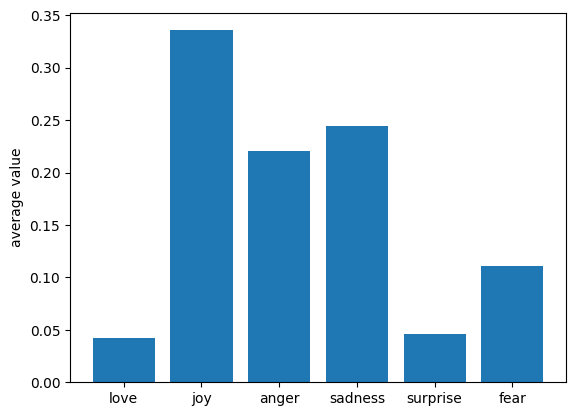

In [26]:
plt.bar(infj_emotions_avg.keys(), infj_emotions_avg.values())
plt.ylabel("average value")

In [33]:
infj_wordcloud = sa.get_wordcloud(infj_posts)

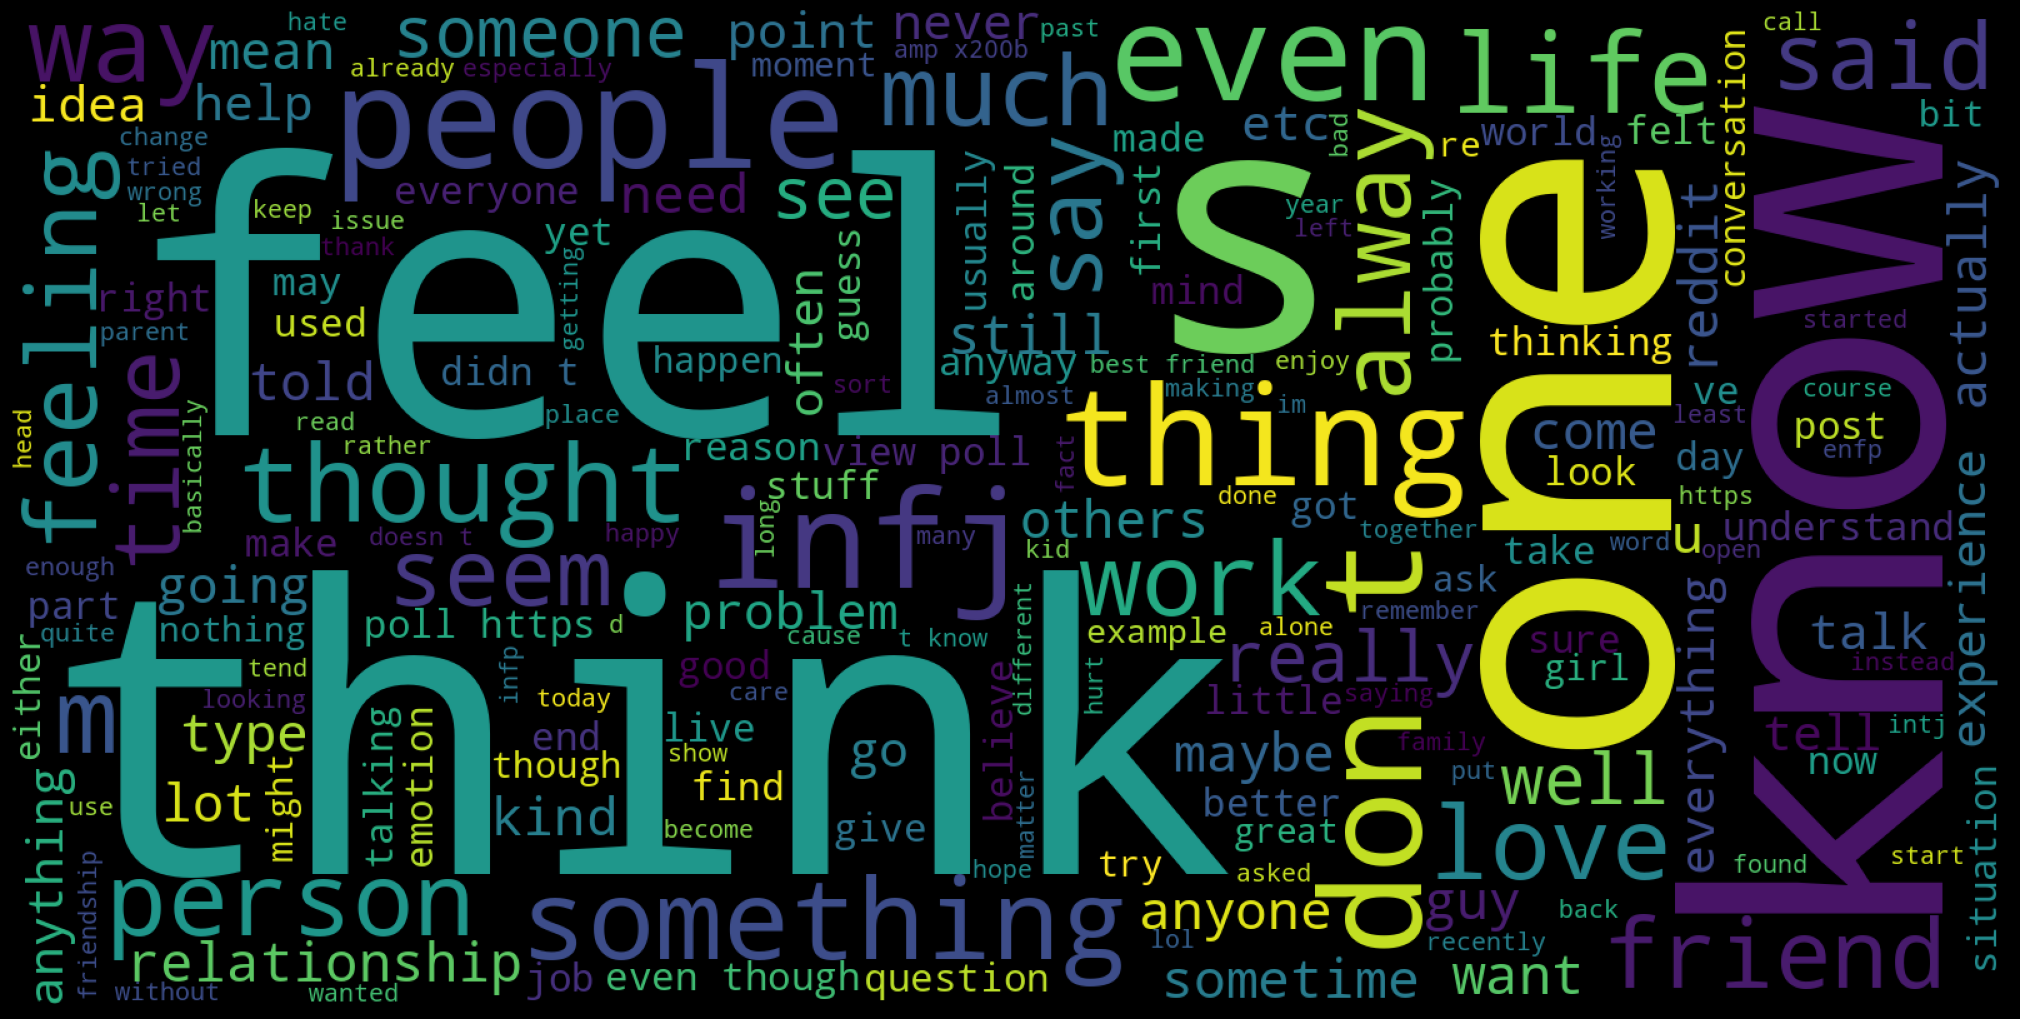

In [34]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(infj_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

__INTJ__

In [27]:
intj_posts = sa.get_posts("intj")
intj_posts.head()

,post_id,post_title,post_body,subreddit_name
0,101nfe,Question about actively engaging Te long after...,After reflecting upon a recent event in my lif...,intj
1,102126,Would you rather date/marry an ISTP or an INFJ?,There are three people left on earth. There's ...,intj
2,1021wg,Would you rather date/marry an ISTP or an INFJ?,There are three people left on earth. There's ...,intj
3,1034xv,Any masterminds out there have experiences wit...,Years ago in university I used Ritalin to help...,intj
4,103683,Any performing musicians amongst us?,"I play the piano to a reasonable level, but su...",intj


In [28]:
intj_sentiment = sa.get_posts_sentiment(intj_posts)
intj_emotions_avg = sa.get_emotions_avg(intj_sentiment, len(intj_posts))
intj_emotions_avg

100%|██████████| 69302/69302 [00:00<00:00, 1271060.13it/s]


{'love': 0.032165332693216434,
 'joy': 0.3439569681613762,
 'anger': 0.2951197296742479,
 'sadness': 0.18925806443728138,
 'surprise': 0.04358893051803849,
 'fear': 0.09591097465825442}

Text(0, 0.5, 'average value')

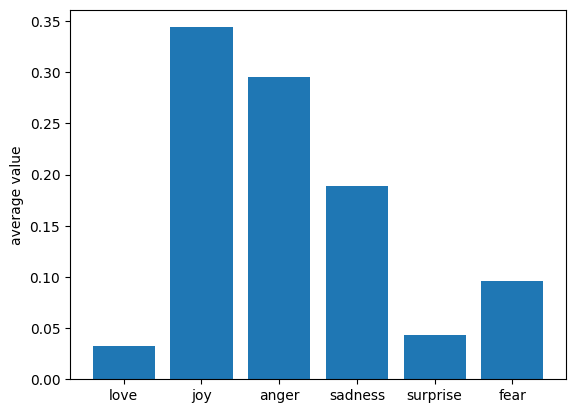

In [30]:
plt.bar(intj_emotions_avg.keys(), intj_emotions_avg.values())
plt.ylabel("average value")

In [36]:
intj_wordcloud = sa.get_wordcloud(intj_posts)

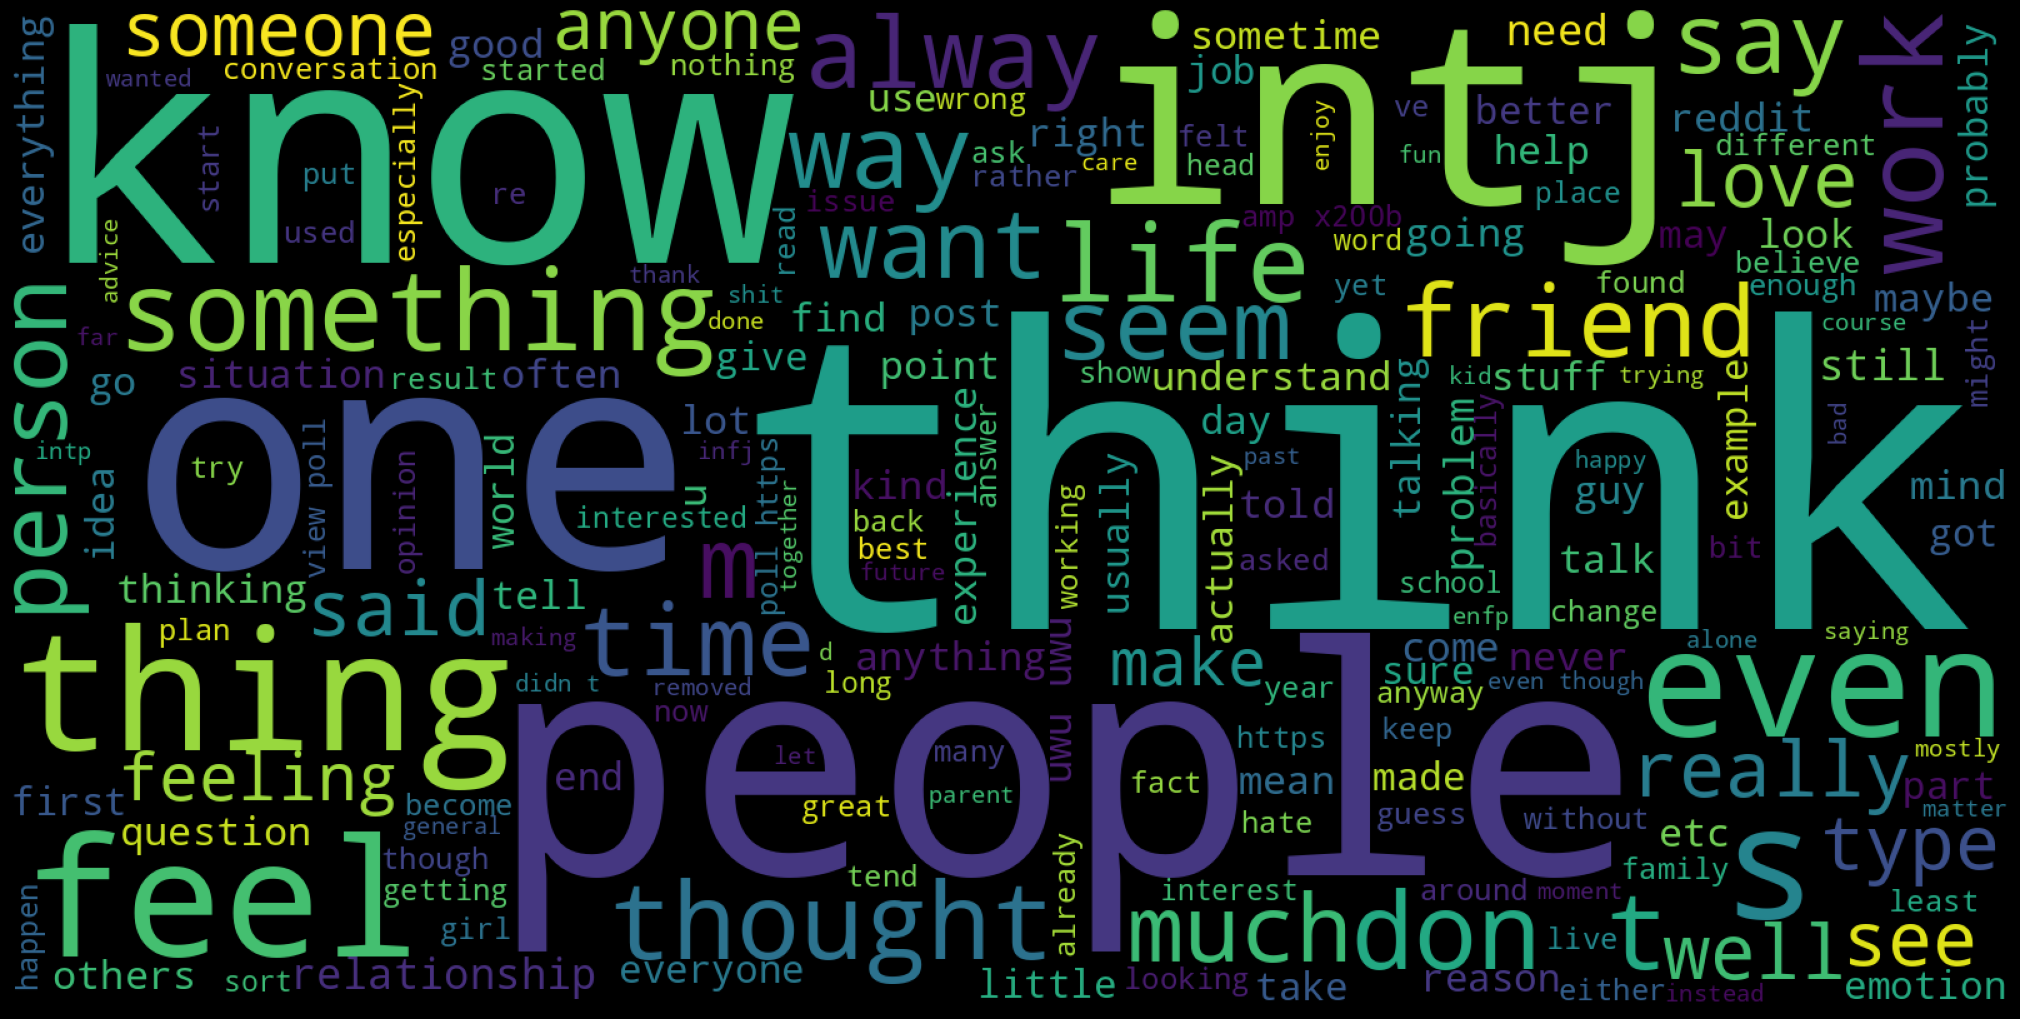

In [39]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(intj_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

__INTJ VS INFJ__

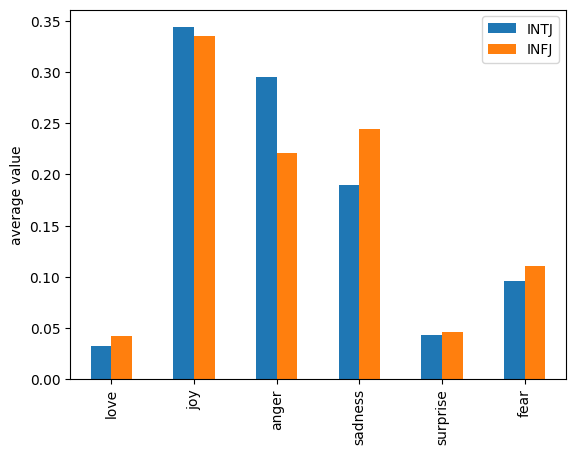

In [32]:
intj_infj = pd.DataFrame(index = intj_emotions_avg.keys())
intj_infj["INTJ"] = intj_emotions_avg.values()
intj_infj["INFJ"] = infj_emotions_avg.values()
intj_infj.plot.bar()
plt.ylabel("average value")
plt.show()